# 1. Importing Libraries and Data

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import statistics
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import callbacks
import keras_tuner
from keras_tuner import RandomSearch, Hyperband
import opendatasets as od

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

# 2. Exploring Data

In [37]:
DATASET_DIR = "FER Dataset"
path_train = f'{DATASET_DIR}/train'
path_test = f'{DATASET_DIR}/test'

In [38]:
def explore_data(path_train, path_test):
  train = {}
  test = {}
  Train_Examples = 0
  Test_Examples = 0
  classes_labels = os.listdir(path_train)
  print("In Train Data:")
  for i, vid in enumerate(classes_labels):
      print("Class %s has %d examples " %(vid, len(os.listdir(f'{path_train}/{vid}'))))
      Train_Examples += len(os.listdir(f'{path_train}/{vid}'))
      train[vid] = len(os.listdir(f'{path_train}/{vid}'))
  print("\nTotal Number of Train Data", Train_Examples)
  plt.bar(list(train.keys()), list(train.values()),width = 0.4)    
  print("--------------")
  print("\nIn Test Data:")
  for i, vid in enumerate(classes_labels):
      Test_Examples += len(os.listdir(f'{path_test}/{vid}'))
      test[vid] = len(os.listdir(f'{path_test}/{vid}'))
      print("Class %s has %d examples " %(vid, len(os.listdir(f'{path_test}/{vid}'))))
  print("\nTotal Number of Test Data", Test_Examples)
  print("\n")
  plt.bar(list(test.keys()), list(test.values()),width = 0.4) 
  return train, test, Train_Examples, Test_Examples, classes_labels

In Train Data:
Class angry has 3993 examples 
Class happy has 7164 examples 
Class neutral has 4982 examples 
Class surprise has 3205 examples 
Class sad has 4938 examples 
Class fear has 4103 examples 
Class disgust has 436 examples 

Total Number of Train Data 28821
--------------

In Test Data:
Class angry has 960 examples 
Class happy has 1825 examples 
Class neutral has 1216 examples 
Class surprise has 797 examples 
Class sad has 1139 examples 
Class fear has 1018 examples 
Class disgust has 111 examples 

Total Number of Test Data 7066




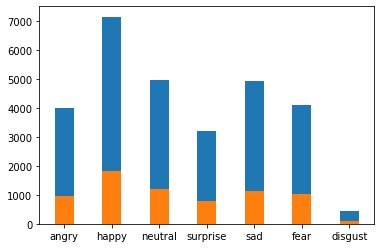

In [42]:
train, test, Train_Examples, Test_Examples, classes_labels = explore_data(path_train, path_test)

In [ ]:
import random
def display_data(train_path, test_path):
  plt.figure(figsize=(10,40))
  for i, vid in enumerate(classes_labels):
    label_images_names = os.listdir(f'{path_train}/{vid}')
    image = plt.imread(f'{path_train}/{vid}/{random.choice(label_images_names)}')
    plt.subplot(7,2,i + 1), plt.imshow(image), plt.title(vid)

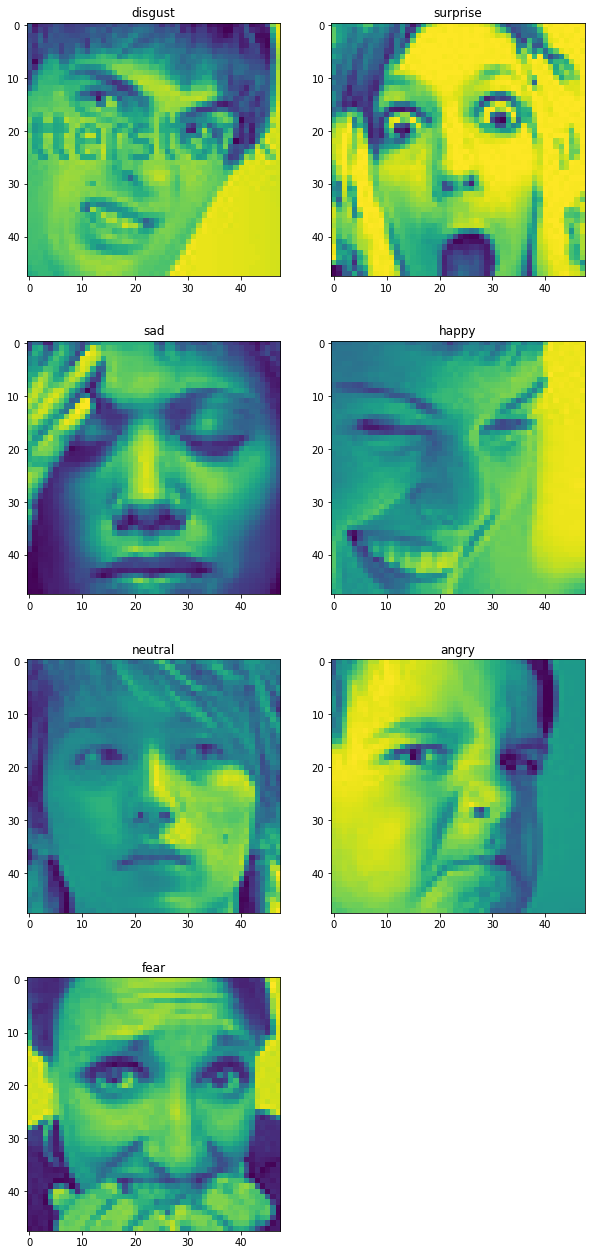

In [ ]:
display_data(path_train, path_test)

# 3. Building Model

In [43]:
#Define HyperParameters

IMAGE_SIZE = 48
NUM_FEATURES = 1024
BATCH_SIZE = 32
EPOCHS = 5
classes_number = len(classes_labels)

In [ ]:
def build_model(hyperaband):
    filters_layer1=hyperaband.Choice('filters_layer1', [32, 64, 128, 256])
    filters_layer2=hyperaband.Choice('filters_layer2', [32, 64, 128, 256])
    filters_layer3=hyperaband.Choice('filters_layer3', [32, 64, 128, 256])
    filters_layer4=hyperaband.Choice('filters_layer4',[32, 64, 128, 256])
    hyperaband_dropout = hyperaband.Choice('drop_out', values=[0.3 , 0.5])
    hyperaband_dense_layer = hyperaband.Choice('dense_layer', [128,256,512])
    model = keras.Sequential([
      keras.layers.Conv2D(filters_layer1, (3, 3), padding='same',activation = 'relu',input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = (2,2)),

      keras.layers.Conv2D(filters_layer2, (3, 3), padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      keras.layers.Conv2D(filters_layer3, (3, 3), padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = (2,2)),

      keras.layers.Conv2D(filters_layer4, (3, 3), padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      keras.layers.Flatten(),
      keras.layers.Dropout(hyperaband_dropout),
      keras.layers.Dense(hyperaband_dense_layer, activation='relu'),
      keras.layers.Dense(classes_number, activation='softmax')
    ])
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                                    rotation_range = 20 ,
                                    width_shift_range = 0.2 ,
                                    height_shift_range = 0.2 ,
                                    shear_range = 0.2 ,
                                    zoom_range = 0.2 ,
                                    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

training_set = train_datagen.flow_from_directory(
    directory= path_train,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="grayscale",
    batch_size= BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42)

testing_set = test_datagen.flow_from_directory(directory = path_test,
      shuffle=False,
      target_size = (IMAGE_SIZE, IMAGE_SIZE),
      batch_size= BATCH_SIZE,
      class_mode = 'categorical',
      color_mode="grayscale")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [44]:
def get_features(examples, path):
    features = np.zeros(shape=(examples, IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32) #float32 to minimze using RAM
    labels = []
    MapToNames = {}
    counter = 0
    for class_index, class_name in enumerate(classes_labels):
        MapToNames [class_index] = class_name
        print(class_name)
        images = os.listdir(f'{path}/{class_name}')
        for e, video_path in enumerate(images):
            image = plt.imread(f'{path}/{class_name}/{video_path}')
            features[counter][:] = image
            labels.append(class_index)
            counter = counter + 1
    return features, labels, MapToNames

In [ ]:
#step_size_train = np.ceil (training_set.samples / BATCH_SIZE)
#step_size_test =np.ceil (test_set.samples / BATCH_SIZE)

def configure_callbacks(lr_plateau_patient, early_stop_patient, best_model_path):
  best_model_file = best_model_path
  bestModel = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)
  earlyStopping = EarlyStopping(monitor = 'val_accuracy', patience = early_stop_patient, mode = 'max', min_delta=0.001, restore_best_weights = True)
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=lr_plateau_patient, mode='max', verbose=1,factor=0.5,min_learning_rate=0.0000001)
  return bestModel, earlyStopping, reduce_lr

In [ ]:
def buildModel(filter_layer1, filter_layer2, filter_layer3, filter_layer4, filter_size, pool_size):
  model = keras.Sequential([
      keras.layers.Conv2D(filter_layer1, filter_size, padding='same',activation = 'relu',input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = pool_size),

      keras.layers.Conv2D(filter_layer2, filter_size, padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = pool_size),
      
      keras.layers.Conv2D(filter_layer3, filter_size, padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = pool_size),

      keras.layers.Conv2D(filter_layer4, filter_size, padding='same',activation = 'relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(pool_size = pool_size),
      
      keras.layers.Flatten(),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(classes_number, activation='softmax')
    ])
  adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
  return model

# 4. Training and Evaluation

In [ ]:
EPOCHS = 100
bestModel, earlyStopping, reduce_lr = configure_callbacks(5, 8, "/models/MyTunedFERModel32_64_128_256.hdf5")
filters_32_64_128_256_model = buildModel(32, 64, 128, 256, (3,3), (2,2))
history32_64_128_256 = filters_32_64_128_256_model.fit(
    train_set,
    to_categorical(train_labels),
    validation_data = (test_set, to_categorical(test_labels)),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    callbacks=[earlyStopping, reduce_lr, bestModel])

Epoch 1/100
901/901 [==============================] - ETA: 0s - loss: 1.6422 - accuracy: 0.3594
Epoch 1: val_accuracy improved from -inf to 0.39004, saving model to /gdrive/MyDrive/MyTunedFERModel32_64_128_256.hdf5
901/901 [==============================] - 11s 9ms/step - loss: 1.6422 - accuracy: 0.3594 - val_loss: 1.5692 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 2/100
896/901 [============================>.] - ETA: 0s - loss: 1.3251 - accuracy: 0.4920
Epoch 2: val_accuracy improved from 0.39004 to 0.50750, saving model to /gdrive/MyDrive/MyTunedFERModel32_64_128_256.hdf5
901/901 [==============================] - 7s 8ms/step - loss: 1.3248 - accuracy: 0.4920 - val_loss: 1.3056 - val_accuracy: 0.5075 - lr: 0.0010
Epoch 3/100
897/901 [============================>.] - ETA: 0s - loss: 1.2002 - accuracy: 0.5413
Epoch 3: val_accuracy did not improve from 0.50750
901/901 [==============================] - 8s 8ms/step - loss: 1.1996 - accuracy: 0.5415 - val_loss: 1.3464 - val_accuracy: 0.49

In [ ]:
def training_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  actualEpochs = range(len(acc))
  print("Actual Epochs : "+ str(actualEpochs))
  
  plt.plot(actualEpochs, acc , 'r', label='Training accuracy')
  plt.plot(actualEpochs, val_acc , 'b', label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  
  plt.show()

In [ ]:
def evaluation_results(model, test_set):
  evalRes = model.evaluate(test_set, to_categorical(test_labels))
  print("Loss: ", evalRes[0])
  print("Accuracy: ", evalRes[1])
  pred=model.predict(test_set)
  predicted_class_indices=np.argmax(pred,axis=1)
  print("F1-Score: ", f1_score(test_labels, predicted_class_indices, average='macro'))
  confusion = confusion_matrix(test_labels, predicted_class_indices)
  plt.figure(figsize=(10,10))
  sns.heatmap(confusion)

# Demo

221/221 [==============================] - 3s 5ms/step - loss: 2.3763 - accuracy: 0.6340
Loss:  2.3763372898101807
Accuracy:  0.634022057056427
221/221 [==============================] - 1s 2ms/step
F1-Score:  0.6207321158744111


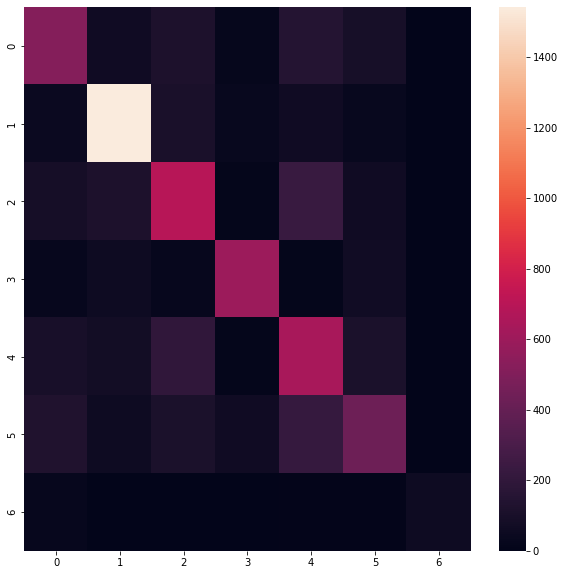

In [47]:
model = load_model("/models/MyTunedFERModel32_64_128_256.h5") #63.40
evaluation_results(model, test_set)

In [ ]:
import random
def test_random_samples(path):
  plt.figure(figsize=(10,40))
  for i, vid in enumerate(classes_labels):
    label_images_names = os.listdir(f'{path}/{vid}')
    image = plt.imread(f'{path}/{vid}/{random.choice(label_images_names)}')
    print(image.shape)
    pred=model.predict(image.reshape(48,48,1))
    predicted_class_index=np.argmax(pred,axis=1)
    plt.subplot(7,2,i + 1), plt.imshow(image), plt.title("Real: " + vid + "\nPrediction: "+ MapToNames[predicted_class_index])

1/1 [==============================] - 0s 20ms/step


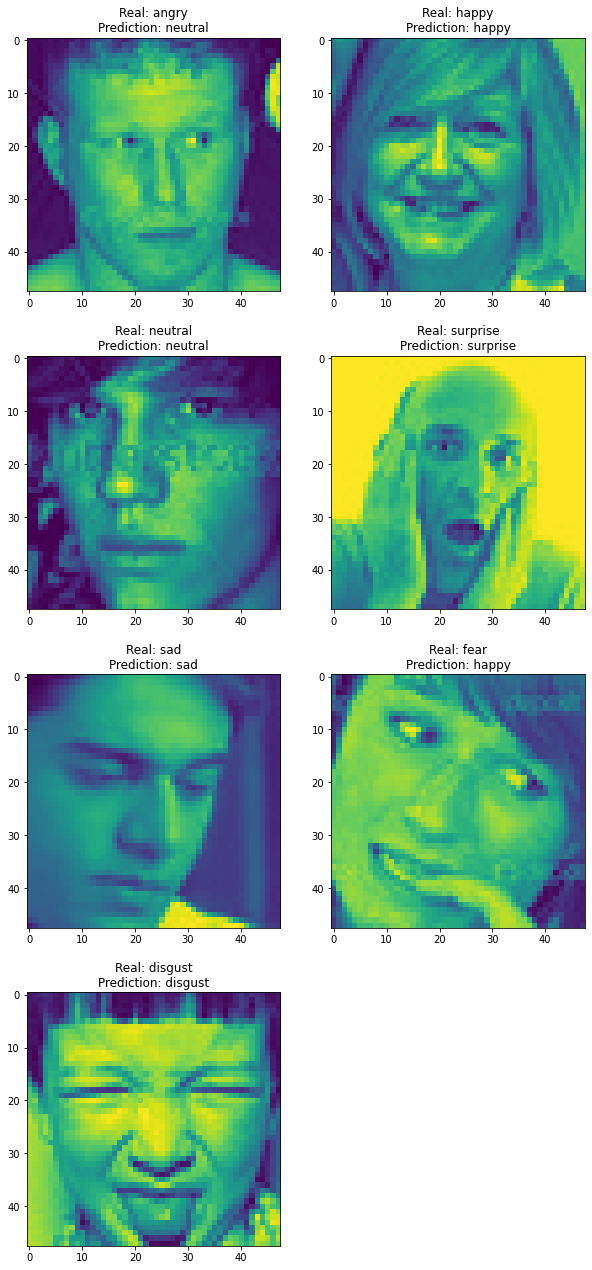

In [ ]:
test_random_samples(path_test)

(640, 640, 3)


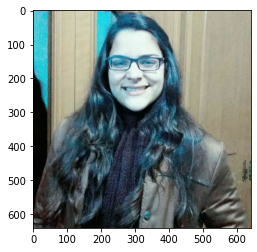

In [ ]:
image = plt.imread('Judy.jpg')
print(image.shape)
plt.imshow(image)

(48, 48)
1/1 [==============================] - 0s 130ms/step


Text(0.5, 1.0, 'Prediction: happy')

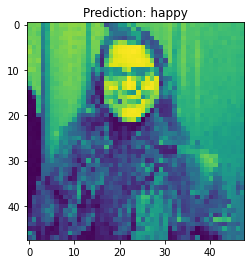

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (48,48))
print(image.shape)
pred=model.predict(image.reshape(1,48,48,1))
predicted_class_index=np.argmax(pred,axis=1)
plt.imshow(image)
plt.title("Prediction: "+ MapToNames[predicted_class_index[0]])

(720, 1280, 3)


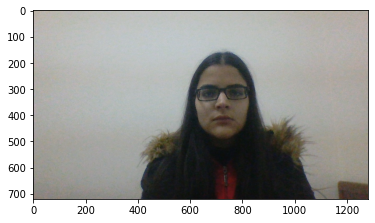

In [ ]:
image = plt.imread('JudyNeutral.jpg')
print(image.shape)
plt.imshow(image)

(48, 48)
1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Prediction: neutral')

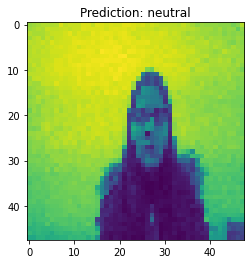

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (48,48))
print(image.shape)
pred=model.predict(image.reshape(1,48,48,1))
predicted_class_index=np.argmax(pred,axis=1)
plt.imshow(image)
plt.title("Prediction: "+ MapToNames[predicted_class_index[0]])

(280, 390, 3)


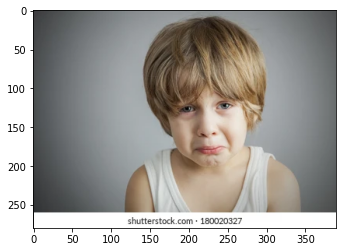

In [51]:
image = plt.imread('sad.jpg')
print(image.shape)
plt.imshow(image)

(48, 48)
1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'Prediction: sad')

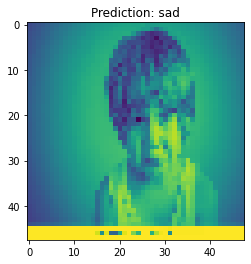

In [52]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (48,48))
print(image.shape)
pred=model.predict(image.reshape(1,48,48,1))
predicted_class_index=np.argmax(pred,axis=1)
plt.imshow(image)
plt.title("Prediction: "+ MapToNames[predicted_class_index[0]])